# Scaling up GNNs with GraphSAGE

In [22]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(-1)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Pubmed

In [23]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [24]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[413, 500], edge_index=[2, 470], y=[413], train_mask=[413], val_mask=[413], test_mask=[413], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[257, 500], edge_index=[2, 305], y=[257], train_mask=[257], val_mask=[257], test_mask=[257], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[280, 500], edge_index=[2, 319], y=[280], train_mask=[280], val_mask=[280], test_mask=[280], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[194, 500], edge_index=[2, 229], y=[194], train_mask=[194], val_mask=[194], test_mask=[194], input_id=[12], batch_size=12)


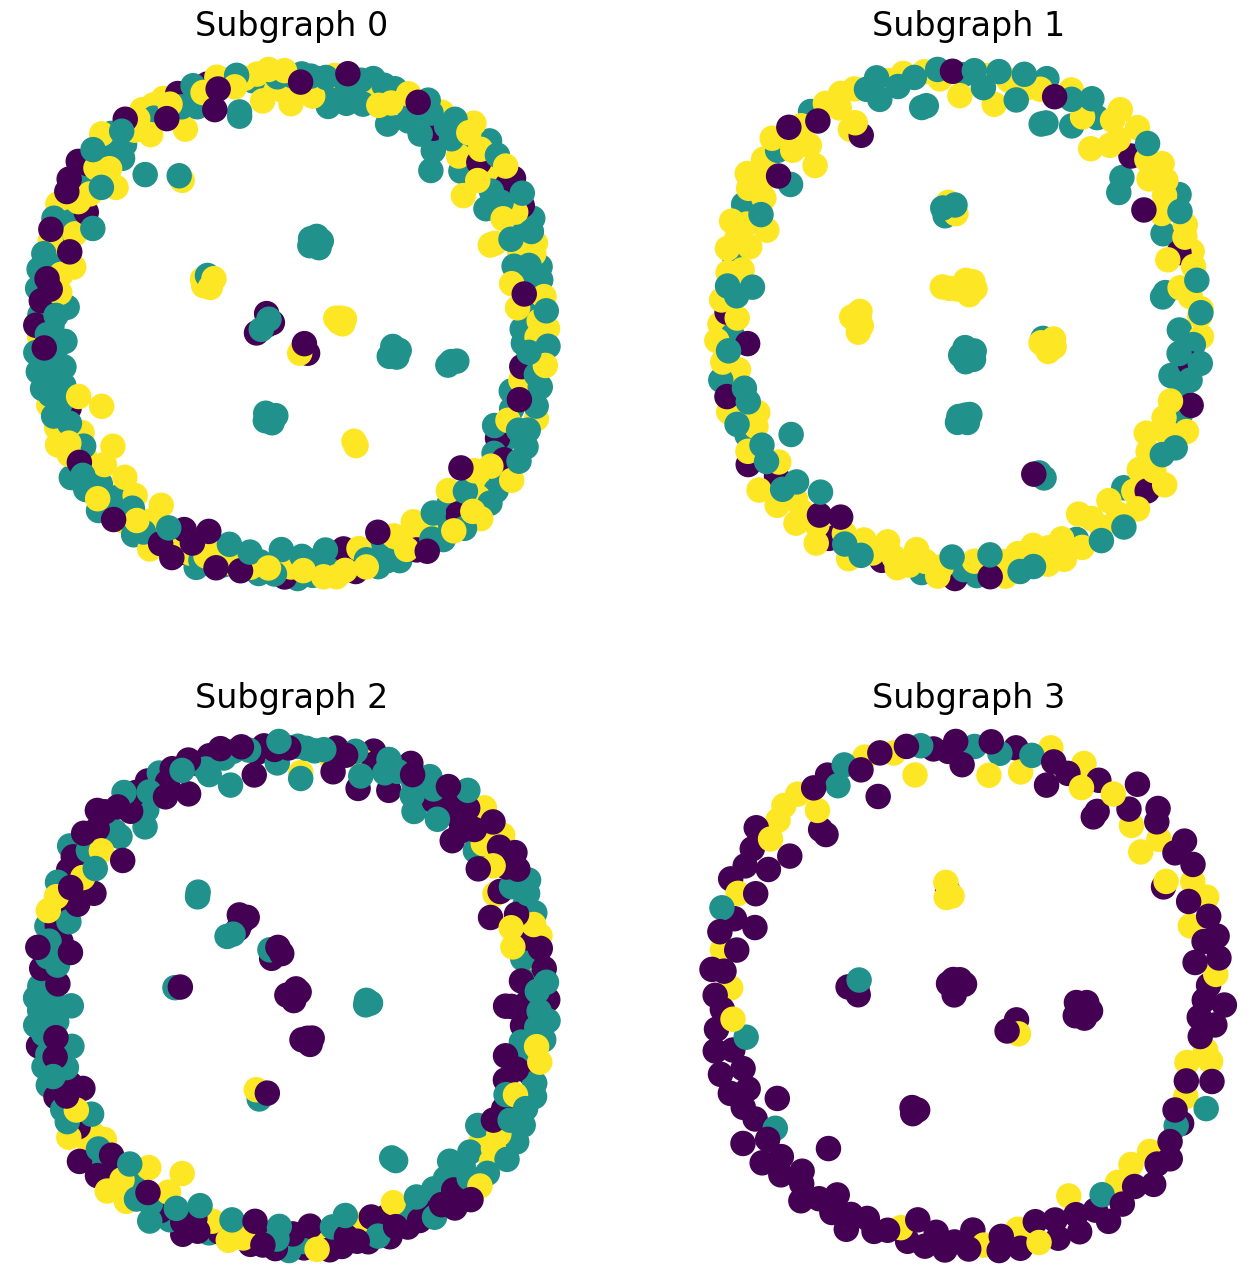

In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [26]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [27]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.317 | Train Acc:  28.77% | Val Loss: 1.13 | Val Acc: 19.55%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 75.07%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 80.56%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.35 | Val Acc: 86.11%
Epoch  80 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 73.58%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.79 | Val Acc: 74.72%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.75%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 67.50%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 73.54%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.47 | Val Acc: 86.11%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00

## PPI

In [28]:
import torch
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training, evaluation, and test sets
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# Unify the training graphs and apply neighbor sampling
train_data = Batch.from_data_list(train_dataset)
loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Evaluation loaders (one datapoint corresponds to a graph)
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

for epoch in range(301):
    loss = fit()
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

print(f'Test F1-score: {test(test_loader):.4f}')

Epoch   0 | Train Loss: 0.589 | Val F1-score: 0.4245
Epoch  50 | Train Loss: 0.194 | Val F1-score: 0.8400
Epoch 100 | Train Loss: 0.143 | Val F1-score: 0.8779
Epoch 150 | Train Loss: 0.123 | Val F1-score: 0.8935
Epoch 200 | Train Loss: 0.107 | Val F1-score: 0.9013
Epoch 250 | Train Loss: 0.104 | Val F1-score: 0.9076
Epoch 300 | Train Loss: 0.090 | Val F1-score: 0.9154
Test F1-score: 0.9360
